In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../../SyMBac/')
sys.path.insert(1, '../../single_cell_projection_diffraction/')
from SyMBac.drawing import raster_cell, convert_to_3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from skimage.transform import rotate
from skimage.transform import rescale
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')
import random
from copy import deepcopy
from SyMBac.renderer import convolve_rescale
from tqdm.auto import tqdm
from joblib import Parallel, delayed

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from matplotlib.colors import LogNorm, AsinhNorm, PowerNorm
from SyMBac.drawing import raster_cell, convert_to_3D
from SyMBac.renderer import convolve_rescale, PSF_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
pix_mic_conv=0.015
resize_amount = 1
def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount = False):


    membrane_thickness = 0.1 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation=0)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, separation=0)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [19]:
membrane_cell = np.pad(raster_membrane_cell_3d(4/pix_mic_conv, 1/pix_mic_conv), ((1,1),(70,70),(70,70)))
print(membrane_cell.shape)

(66, 406, 206)


In [20]:
a_cell = np.pad(raster_cell(4/pix_mic_conv, 1/pix_mic_conv, separation = 0), (70,70))
a_cell_3D = convert_to_3D(a_cell)

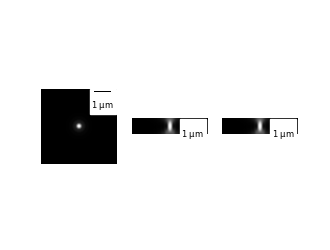

In [21]:
my_kernel = PSF_generator(
    radius = 150, 
    wavelength = 0.6, 
    NA=1.49, 
    n = 1.5, 
    resize_amount=1, 
    pix_mic_conv=0.015, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = a_cell_3D.shape[0],
    pz = 0.5,
    working_distance = 170
)
my_kernel.calculate_PSF()
my_kernel.kernel /= np.sum(my_kernel.kernel) # normalise so kernel sums to 1
my_kernel.plot_PSF()

In [22]:
coords = np.argwhere(a_cell_3D)
rng = np.random.default_rng()

In [23]:
conv_cells = []
for molecule_count in [10, 100, 1000, 10000]:
    random_coords = rng.choice(coords, molecule_count, replace=False)
    
    empty_cell = np.zeros_like(a_cell_3D)
    for coord in random_coords:
        empty_cell[coord[0], coord[1], coord[2]] = 1
    conv_cell_3D = np.array([convolve_rescale(cell_layer.astype(float), kernel_layer, rescale_factor=1, rescale_int=False) for cell_layer, kernel_layer in tqdm(zip(empty_cell, my_kernel.kernel))])
    conv_cells.append(conv_cell_3D)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

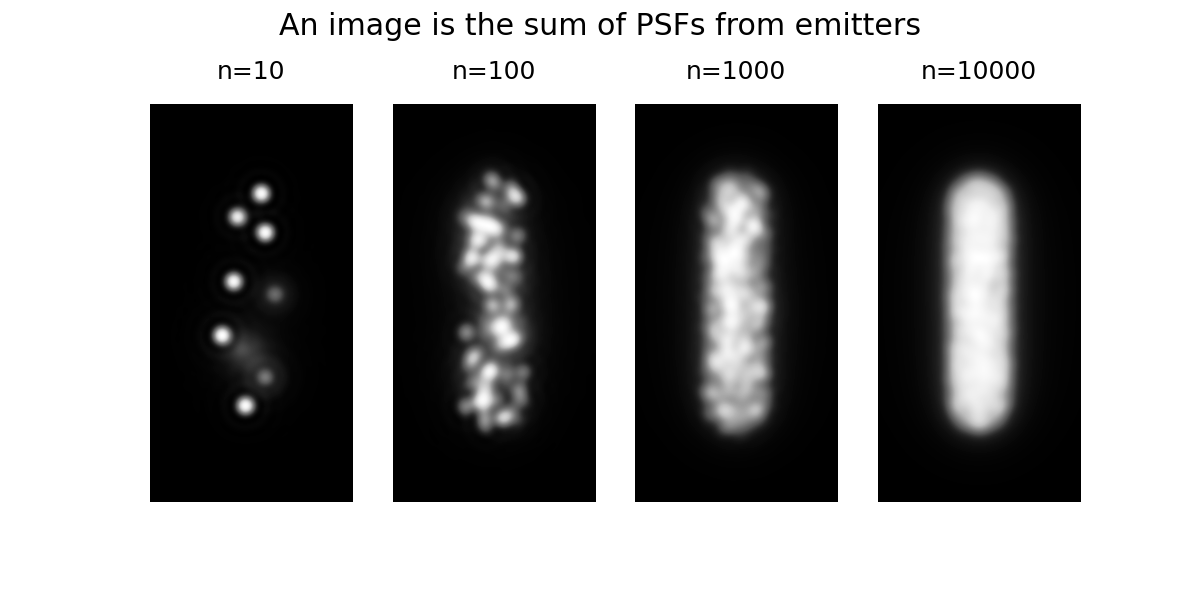

In [24]:
fig, (axs) = plt.subplots(1, 4, figsize=(4,2), dpi = 300)
axs[0].imshow(conv_cells[0].sum(axis=0), cmap = "Greys_r")
axs[0].set_title(f"n=10")
axs[1].imshow(conv_cells[1].sum(axis=0), cmap = "Greys_r")
axs[1].set_title(f"n=100")
axs[2].imshow(conv_cells[2].sum(axis=0), cmap = "Greys_r")
axs[2].set_title(f"n=1000")
axs[3].imshow(conv_cells[3].sum(axis=0), cmap = "Greys_r")
axs[3].set_title(f"n=10000")
for ax in axs:
    ax.axis("off")
plt.suptitle("An image is the sum of PSFs from emitters")
plt.savefig("cyto.svg")

In [11]:
coords = np.argwhere(membrane_cell)
rng = np.random.default_rng()

In [12]:
conv_cells = []
for molecule_count in [10, 100, 1000, 10000]:
    random_coords = rng.choice(coords, molecule_count, replace=False)
    
    empty_cell = np.zeros_like(a_cell_3D)
    for coord in random_coords:
        empty_cell[coord[0], coord[1], coord[2]] = 1
    conv_cell_3D = np.array([convolve_rescale(cell_layer.astype(float), kernel_layer, rescale_factor=1, rescale_int=False) for cell_layer, kernel_layer in tqdm(zip(empty_cell, my_kernel.kernel))])
    conv_cells.append(conv_cell_3D)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

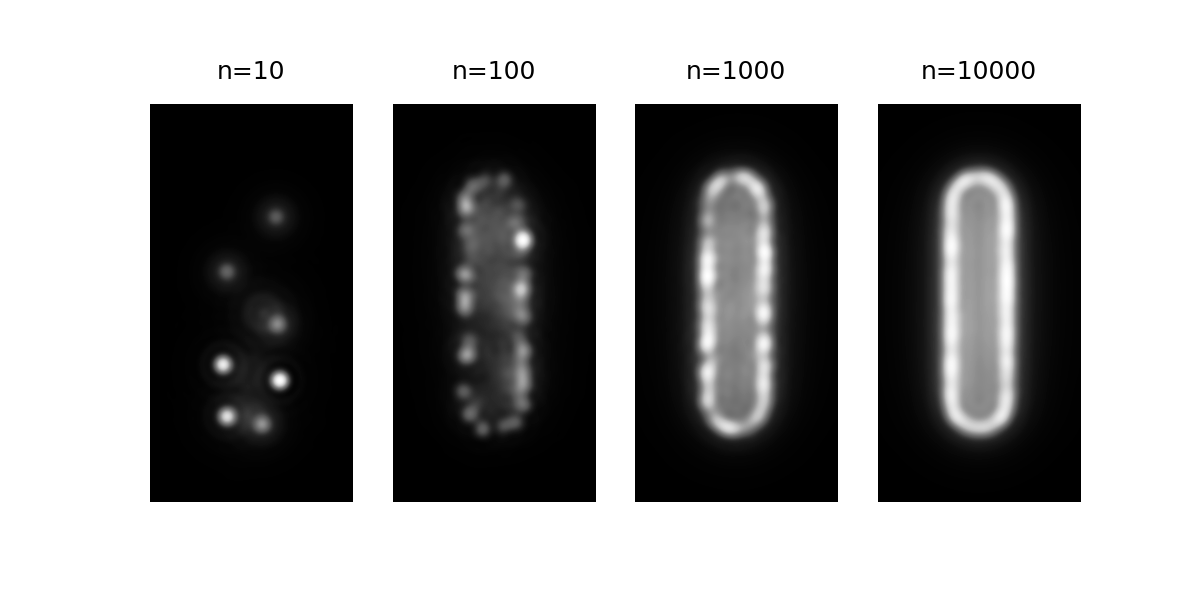

In [17]:
fig, (axs) = plt.subplots(1, 4, figsize=(4,2), dpi = 300)
axs[0].imshow(conv_cells[0].sum(axis=0), cmap = "Greys_r")
axs[0].set_title(f"n=10")
axs[1].imshow(conv_cells[1].sum(axis=0), cmap = "Greys_r")
axs[1].set_title(f"n=100")
axs[2].imshow(conv_cells[2].sum(axis=0), cmap = "Greys_r")
axs[2].set_title(f"n=1000")
axs[3].imshow(conv_cells[3].sum(axis=0), cmap = "Greys_r")
axs[3].set_title(f"n=10000")
for ax in axs:
    ax.axis("off")
plt.savefig("membrane.svg")